#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## Simone Trevisan 1238612

# Regression task

## Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset,ChainDataset
from torchvision import transforms
from sklearn.model_selection import KFold

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2020-12-28 16:59:27--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv.1’

train_data.csv.1    100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-12-28 16:59:27 (75.5 MB/s) - ‘regression_dataset/train_data.csv.1’ saved [3776/3776]

--2020-12-28 16:59:27--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘r

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [ ]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

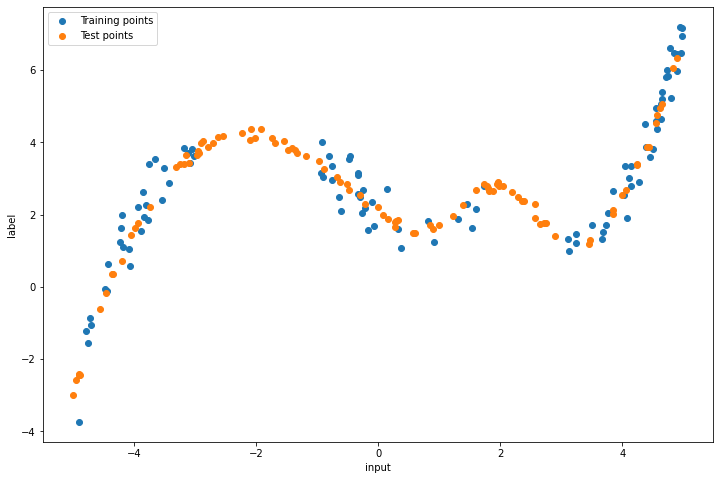

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

**Dataset**

In [ ]:
class CsvDataset(Dataset):

  def __init__(self, csv_file, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform
    # Read the file and split the lines in a list
    with open(csv_file, 'r') as f:
      lines = f.read().split('\n')
    # Get x and y values from each line and append to self.data
    self.data = []
    skip_first_line = 1
    for line in lines:
      if skip_first_line:
        skip_first_line = 0
        continue
      sample = line.split(',')
      if (not sample[0]) or (not (sample[1])):
        continue
      self.data.append((float(sample[0]), float(sample[1])))
    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    # The length of the dataset is simply the length of the self.data list
    return len(self.data)

  def __getitem__(self, idx):
    # Our sample is the element idx of the list self.data
    sample = self.data[idx]
    if self.transform:
        sample = self.transform(sample)
    return sample

  def __random_split__(self,k):
    random_split(self,k)

class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
        
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)

## Network Definition

In [ ]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        #print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.do1 = nn.Dropout(p=0.0)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.do2 = nn.Dropout(p=0.0)
        self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
        self.do3 = nn.Dropout(p=0.0)
        self.out = nn.Linear(in_features=Nh3, out_features=No)
        self.act1 = nn.SELU()
        self.act2 = nn.Sigmoid()

        #weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight.data, a=0, mode='fan_in')
        nn.init.normal_(self.fc2.weight.data, mean=0.0, std=1.0)
        nn.init.normal_(self.fc3.weight.data, mean=0.0, std=1.0)
        nn.init.normal_(self.out.weight.data, mean=0.0, std=1.0)

        
    def forward(self, x, additional_out=False):
        x = self.act1(self.do1(self.fc1(x)))
        x = self.act2(self.do2(self.fc3(x)))
        x = self.out(x)

        return x

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 16 #50 #64
Nh2 = 16#200 #64
Nh3 = 64 #50 #32
No = 1
net = Net(Ni, Nh1, Nh2, Nh3, No)
net.to(device)

# Define the loss function
loss_fn = nn.MSELoss()


Training device: cuda


In [ ]:
from torchsummary import summary

summary(net, input_size=(1, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1, 1, 16]              32
           Dropout-2             [-1, 1, 1, 16]               0
              SELU-3             [-1, 1, 1, 16]               0
            Linear-4             [-1, 1, 1, 64]           1,088
           Dropout-5             [-1, 1, 1, 64]               0
           Sigmoid-6             [-1, 1, 1, 64]               0
            Linear-7              [-1, 1, 1, 1]              65
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## Training

**Plot losses:**

In [ ]:
### TRAINING LOOP


def hyperparameter_tuning(net, train_dataset, lr, decay, batchsize):
  num_epochs = 5000

  train_loss_log = []
  val_loss_log = []
  fold = 0

  kf = KFold(n_splits=5, shuffle=False)
  for train_index, val_index in kf.split(train_dataset):
    t_loss_log = []
    v_loss_log = []
    X_train = [train_dataset[t] for t in train_index]
    X_val = [train_dataset[v] for v in val_index]
    val_dataloader  = DataLoader(X_val,  batch_size=len(X_val), shuffle=False, num_workers=0)
    train_dataloader  = DataLoader(X_train,  batch_size=batchsize, shuffle=False, num_workers=0)

    net = Net(Ni, Nh1, Nh2, Nh3, No)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr= lr, weight_decay=decay)

    flag = 1
    cnt = 0
    min_loss = math.inf

    for epoch_num in range(num_epochs):

      ### TRAIN
      epoch_loss= []
      net.train() # Training mode (e.g. enable dropout)
      for sample_batched in train_dataloader:
          # Move data to device
          x_batch = sample_batched[0].to(device)
          label_batch = sample_batched[1].to(device)

          # Forward pass
          out = net(x_batch)

          # Compute loss
          loss = loss_fn(out, label_batch)

          # Backpropagation
          net.zero_grad()
          loss.backward()

          # Update the weights
          optimizer.step()

          # Save train loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          epoch_loss.append(loss_batch)

      # Save average train loss
      epoch_loss = np.mean(epoch_loss)
      t_loss_log.append(epoch_loss)

      ### VALIDATION
      val_loss= []
      net.eval() # Evaluation mode (e.g. disable dropout)
      with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
          # Move data to device
          x_batch = sample_batched[0].to(device)
          label_batch = sample_batched[1].to(device)

          # Forward pass
          out = net(x_batch)

          # Compute loss
          loss = loss_fn(out, label_batch)

          # Save val loss for this batch
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)

      # Save average validation loss
      val_loss = np.mean(val_loss)
      v_loss_log.append(val_loss)

      # Early stopping
      if val_loss < min_loss:
        min_loss = val_loss



    # Save min val loss
    val_loss_log.append(min_loss)
    fold += 1

  results = {
      "lr" : lr,
      "decay" : decay,
      "batchsize" : batchsize,
      "mean val loss" : np.mean(val_loss_log)
  }

  return results


In [ ]:
#hyperparameter_tuning(net, train_dataset, 1, 2, 3)
lr_grid = [5e-4, 4e-4, 6e-4]
decay_grid = [13e-4, 15e-4, 17e-4]
batchsize_grid = [50]
models = []

for lr in lr_grid:
  for decay in decay_grid:
    for batchsize in batchsize_grid:
      ris = hyperparameter_tuning(net, train_dataset, lr, decay, batchsize)
      models.append(ris)

In [ ]:
models = sorted(models, key=lambda k: k['mean val loss'])
print(models)
best_model = models[0]
best_model

[{'lr': 0.0004, 'decay': 0.0015, 'batchsize': 50, 'mean val loss': 0.28660506}, {'lr': 0.0006, 'decay': 0.0013, 'batchsize': 50, 'mean val loss': 0.34755296}, {'lr': 0.0004, 'decay': 0.0013, 'batchsize': 50, 'mean val loss': 0.3514977}, {'lr': 0.0006, 'decay': 0.0015, 'batchsize': 50, 'mean val loss': 0.37236625}, {'lr': 0.0004, 'decay': 0.0017, 'batchsize': 50, 'mean val loss': 0.39797226}, {'lr': 0.0005, 'decay': 0.0013, 'batchsize': 50, 'mean val loss': 0.39838514}, {'lr': 0.0005, 'decay': 0.0017, 'batchsize': 50, 'mean val loss': 0.5022294}, {'lr': 0.0005, 'decay': 0.0015, 'batchsize': 50, 'mean val loss': 0.57170856}, {'lr': 0.0006, 'decay': 0.0017, 'batchsize': 50, 'mean val loss': 0.97791195}]


{'batchsize': 50, 'decay': 0.0015, 'lr': 0.0004, 'mean val loss': 0.28660506}

In [ ]:
#best_model = {'batchsize': 50, 'decay': 0.0015, 'lr': 0.0004, 'mean val loss': 0.28660506}

In [ ]:
### TRAINING LOOP

num_epochs = 50000
flag = 1
flag2 = 1
train_loss_log = []

train_dataloader  = DataLoader(train_dataset,  batch_size=best_model["batchsize"], shuffle=True, num_workers=0)
net = Net(Ni, Nh1, Nh2, Nh3, No)
net.to(device)
optimizer = optim.Adam(net.parameters(), lr= best_model["lr"], weight_decay=best_model["decay"])



for epoch_num in range(num_epochs):

  ### TRAIN
  epoch_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
      # Move data to device
      x_batch = sample_batched[0].to(device)
      label_batch = sample_batched[1].to(device)

      # Forward pass
      out = net(x_batch)

      # Compute loss
      loss = loss_fn(out, label_batch)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      epoch_loss.append(loss_batch)

  # Save average train loss
  epoch_loss = np.mean(epoch_loss)
  if not epoch_num%200:
    print(f"TRAIN LOSS: {epoch_loss}")
  train_loss_log.append(epoch_loss)

     # Early stopping
  if epoch_loss < 0.195 and flag:
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 
    #scheduler.step()
    #optimizer = optim.Adagrad(net.parameters(), lr= best_model["lr"]/10, weight_decay=best_model["decay"]*2)
    flag = 0
  if epoch_loss < 0.180 and not(flag2):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01) 
    scheduler.step()
    flag2 = 0


TRAIN LOSS: 32.64984130859375
TRAIN LOSS: 1.5586479902267456
TRAIN LOSS: 1.105459451675415
TRAIN LOSS: 0.9209275245666504
TRAIN LOSS: 0.6766196489334106
TRAIN LOSS: 0.48942285776138306
TRAIN LOSS: 0.4186074733734131
TRAIN LOSS: 0.3614414632320404
TRAIN LOSS: 0.3240032196044922
TRAIN LOSS: 0.2832486033439636
TRAIN LOSS: 0.2655380368232727
TRAIN LOSS: 0.2508888840675354
TRAIN LOSS: 0.23964345455169678
TRAIN LOSS: 0.23137632012367249
TRAIN LOSS: 0.2249264121055603
TRAIN LOSS: 0.21817147731781006
TRAIN LOSS: 0.21478265523910522
TRAIN LOSS: 0.21184220910072327
TRAIN LOSS: 0.209314227104187
TRAIN LOSS: 0.20730307698249817
TRAIN LOSS: 0.20540490746498108
TRAIN LOSS: 0.2040664404630661
TRAIN LOSS: 0.20301871001720428
TRAIN LOSS: 0.2022346407175064
TRAIN LOSS: 0.201274573802948
TRAIN LOSS: 0.20148253440856934
TRAIN LOSS: 0.19986796379089355
TRAIN LOSS: 0.19971579313278198
TRAIN LOSS: 0.19980934262275696
TRAIN LOSS: 0.19823434948921204
TRAIN LOSS: 0.19894227385520935
TRAIN LOSS: 0.19745200872421

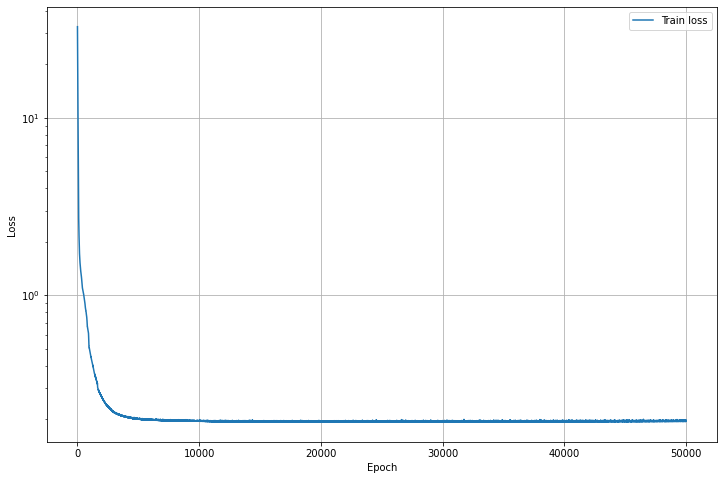

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Network Analysis

**Network Output**

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


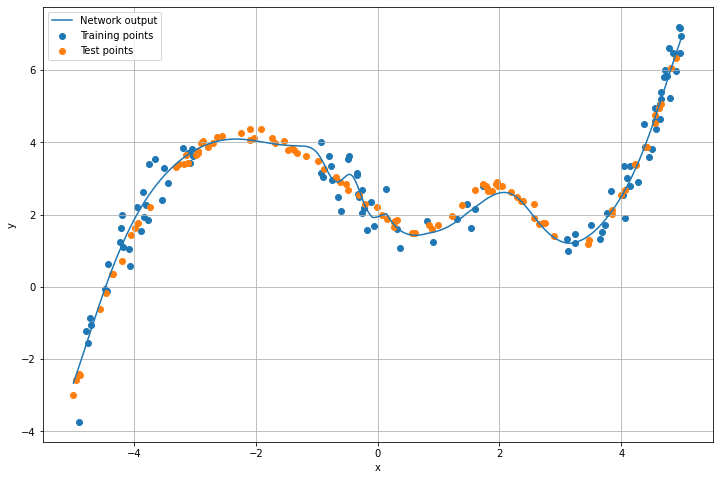

In [ ]:
# Input vector
net.eval()
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)
print(f"Input shape: {x_vec.shape}")

# Network output
with torch.no_grad():
  y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

In [ ]:
### TEST
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)
losses= []
net.eval() # Test mode
for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Save loss
    loss_batch = loss.detach().cpu().numpy()
    losses.append(loss_batch)

# Save average train loss
losses = np.mean(losses)

print(f"TEST LOSS: {losses}")

TEST LOSS: 0.038592204451560974


**Weigths histogram**

In [ ]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = net.fc2.weight.data.cpu().numpy()
h3_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

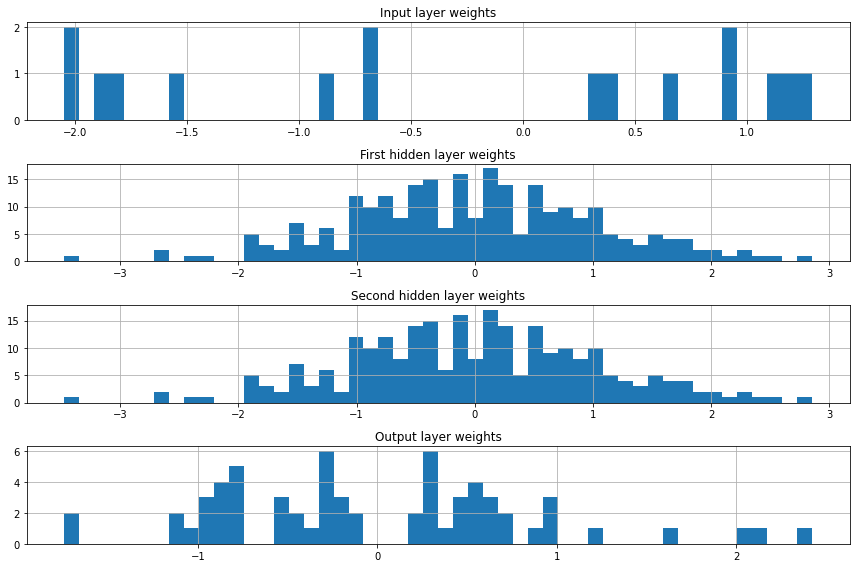

In [ ]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('Input layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('First hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Second hidden layer weights')
axs[3].hist(out_w.flatten(), 50)
axs[3].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

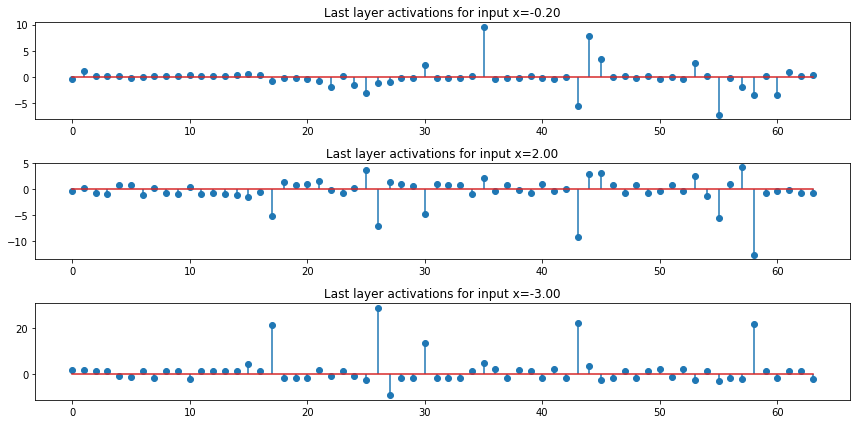

In [ ]:

activation = {}
def get_activation(layer, input, output):
    global activation
    activation = output #before activation function

### Register hook  

net.eval()
hook_handle = net.fc3.register_forward_hook(get_activation)


x1 = torch.tensor([-0.2]).float().to(device)
y1 = net(x1)
z1 = activation
x2 = torch.tensor([2]).float().to(device)
y2 = net(x2)
z2 = activation
x3 = torch.tensor([-3]).float().to(device)
y3= net(x3)
z3 = activation

hook_handle.remove()



fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().detach().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().detach().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().detach().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()